In [8]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [9]:
# Memuat dataset dan mempersiapkan data
df = pd.read_csv("./data/fitness_tracker_dataset.csv").drop(columns=["user_id","date"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steps               1000000 non-null  int64  
 1   calories_burned     1000000 non-null  float64
 2   distance_km         1000000 non-null  float64
 3   active_minutes      1000000 non-null  int64  
 4   sleep_hours         1000000 non-null  float64
 5   heart_rate_avg      1000000 non-null  int64  
 6   workout_type        856880 non-null   object 
 7   weather_conditions  1000000 non-null  object 
 8   location            1000000 non-null  object 
 9   mood                1000000 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 76.3+ MB


In [11]:
df = df.drop(columns=[ "location"])

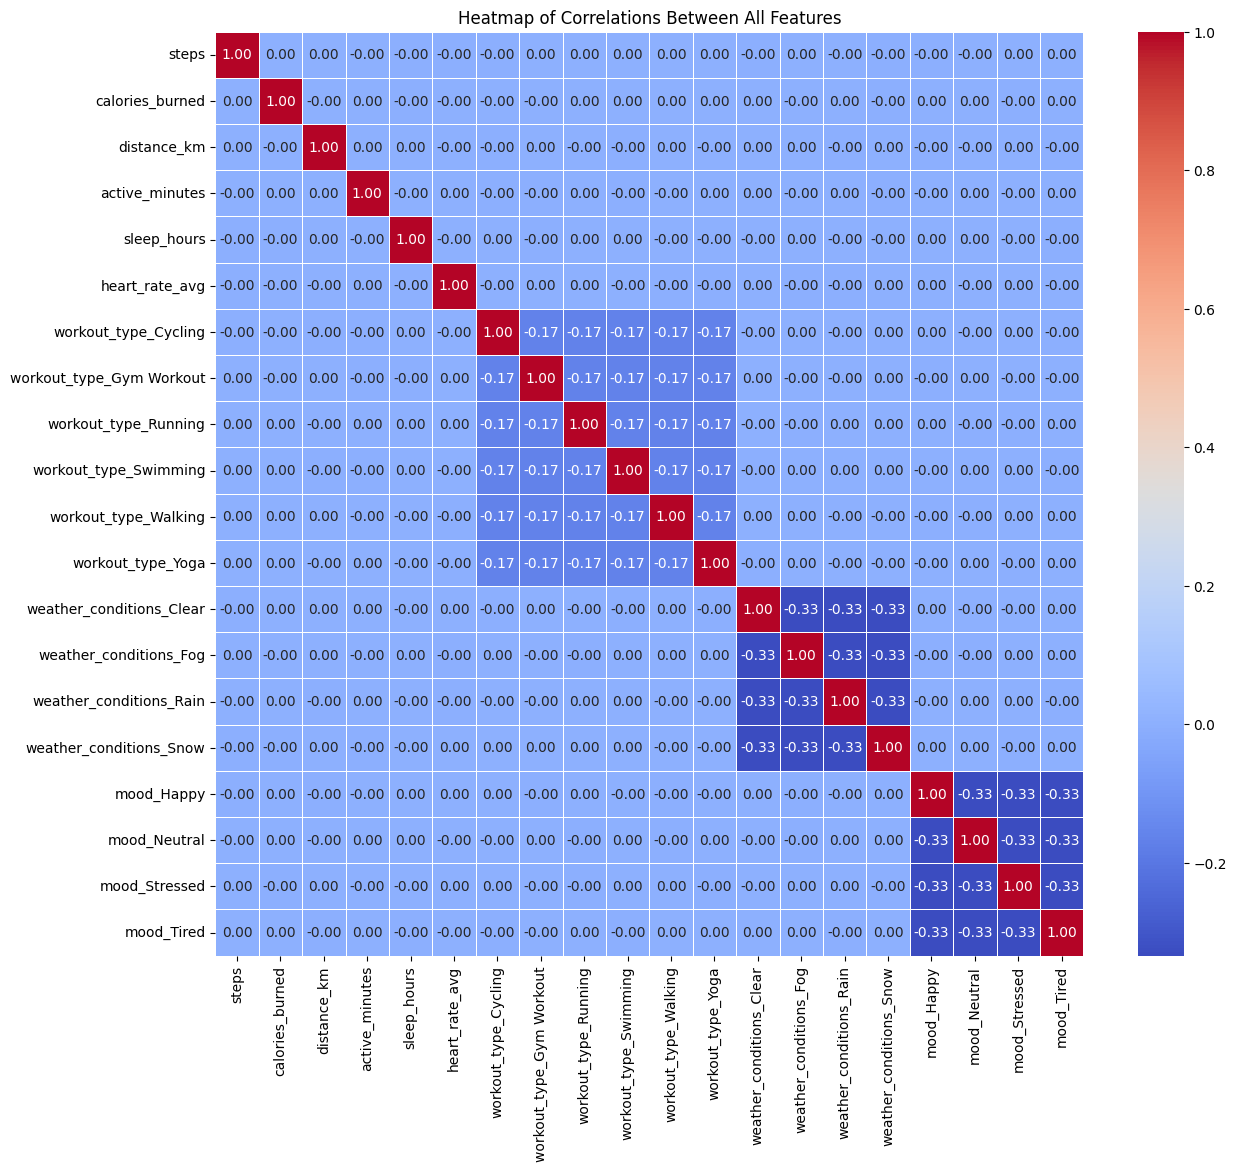

In [12]:
df_encoded = pd.get_dummies(df)

correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Correlations Between All Features")
plt.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steps               1000000 non-null  int64  
 1   calories_burned     1000000 non-null  float64
 2   distance_km         1000000 non-null  float64
 3   active_minutes      1000000 non-null  int64  
 4   sleep_hours         1000000 non-null  float64
 5   heart_rate_avg      1000000 non-null  int64  
 6   workout_type        856880 non-null   object 
 7   weather_conditions  1000000 non-null  object 
 8   mood                1000000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 68.7+ MB


In [14]:
df = df.dropna(subset=["workout_type"])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 856880 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   steps               856880 non-null  int64  
 1   calories_burned     856880 non-null  float64
 2   distance_km         856880 non-null  float64
 3   active_minutes      856880 non-null  int64  
 4   sleep_hours         856880 non-null  float64
 5   heart_rate_avg      856880 non-null  int64  
 6   workout_type        856880 non-null  object 
 7   weather_conditions  856880 non-null  object 
 8   mood                856880 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 65.4+ MB


In [15]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [16]:
class ELM:
    def __init__(self, n_hidden_neurons=10, activation_function='sigmoid'):
        self.n_hidden_neurons = n_hidden_neurons
        self.activation_function = activation_function
        self.W = None  # Bobot input ke lapisan tersembunyi
        self.B = None  # Bobot output dari lapisan tersembunyi

    def _activation(self, X):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-X))
        elif self.activation_function == 'tanh':
            return np.tanh(X)
        elif self.activation_function == 'relu':
            return np.maximum(0, X)
        else:
            raise ValueError("Unsupported activation function")

    def fit(self, X_train, y_train):
        # Menghitung bobot input ke lapisan tersembunyi secara acak
        n_samples, n_features = X_train.shape
        self.W = np.random.randn(n_features, self.n_hidden_neurons)  # Bobot input ke lapisan tersembunyi
        self.B = np.random.randn(self.n_hidden_neurons)  # Bias lapisan tersembunyi

        # Menghitung aktivasi lapisan tersembunyi
        H = self._activation(X_train.dot(self.W) + self.B)

        # Hitung bobot output menggunakan metode analitik
        self.beta = np.linalg.pinv(H).dot(y_train)

    def predict(self, X_test):
        # Menghitung aktivasi lapisan tersembunyi untuk data uji
        H_test = self._activation(X_test.dot(self.W) + self.B)

        # Prediksi hasil output
        y_pred = H_test.dot(self.beta)
        return y_pred


In [17]:
class LVQ:
    def __init__(self, n_prototypes_per_class=1, learning_rate=0.1, max_iter=100, clip_value=1e6):
        self.n_prototypes_per_class = n_prototypes_per_class
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.prototypes = []  # Menyimpan prototipe (setiap prototipe berisi [vektor fitur, kelas])
        self.clip_value = clip_value  # Batas untuk pembaruan prototipe
    
    def fit(self, X_train, y_train):
        # Jika y_train adalah numpy.ndarray, konversi menjadi pandas Series
        if isinstance(y_train, np.ndarray):
            y_train = pd.Series(y_train)
        
        # Normalisasi data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        
        # Reset indeks untuk memastikan konsistensi
        X_train = pd.DataFrame(X_train)  # Pastikan X_train dalam bentuk DataFrame
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        
        classes = np.unique(y_train)
        for c in classes:
            # Pilih secara acak data untuk setiap kelas sebagai prototipe awal
            class_data = X_train[y_train == c]
            for i in range(self.n_prototypes_per_class):
                prototype = class_data.iloc[np.random.choice(class_data.shape[0])]
                self.prototypes.append([prototype.values.astype(np.float64), c])  # Mengonversi prototipe ke float64
        
        # Training LVQ
        for _ in range(self.max_iter):
            print(f"epoch : {_}")
            for i in range(X_train.shape[0]):
                x = X_train.iloc[i].values.astype(np.float64)  # Ubah x menjadi float64
                y_true = y_train.iloc[i]  # Kelas sebenarnya
                
                # Cari prototipe terdekat
                distances = [euclidean_distance(x, prototype[0]) for prototype in self.prototypes]
                closest_prototype_idx = np.argmin(distances)
                closest_prototype, closest_class = self.prototypes[closest_prototype_idx]
                
                # Update prototipe berdasarkan apakah kelas sama atau tidak
                if closest_class == y_true:
                    # Pindahkan prototipe mendekati data
                    self.prototypes[closest_prototype_idx][0] += self.learning_rate * (x - closest_prototype)
                else:
                    # Pindahkan prototipe menjauh dari data
                    self.prototypes[closest_prototype_idx][0] -= self.learning_rate * (x - closest_prototype)

                # Pembatasan pada pembaruan prototipe
                self.prototypes[closest_prototype_idx][0] = np.clip(self.prototypes[closest_prototype_idx][0], -self.clip_value, self.clip_value)
    
    def predict(self, X_test):
        # Normalisasi data uji
        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)
        
        X_test = pd.DataFrame(X_test)  # convart x_test ke dataframe
        X_test = X_test.reset_index(drop=True)
        predictions = []
        for i in range(X_test.shape[0]):
            x = X_test.iloc[i].values.astype(np.float64)  # convert x menjadi float64
            
            # Cari prototipe terdekat
            distances = [euclidean_distance(x, prototype[0]) for prototype in self.prototypes]
            closest_prototype_idx = np.argmin(distances)
            closest_class = self.prototypes[closest_prototype_idx][1]
            
            predictions.append(closest_class)
        
        return np.array(predictions)


In [18]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size, learning_rate=0.01, epochs=1000):
        self.input_size = input_size
        self.hidden_layer1_size = hidden_layer1_size
        self.hidden_layer2_size = hidden_layer2_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # Inisialisasi bobot secara acak
        self.W1 = np.random.randn(input_size, hidden_layer1_size)  # Bobot input ke hidden layer 1
        self.b1 = np.zeros((1, hidden_layer1_size))  # Bias untuk hidden layer 1
        
        self.W2 = np.random.randn(hidden_layer1_size, hidden_layer2_size)  # Bobot hidden layer 1 ke hidden layer 2
        self.b2 = np.zeros((1, hidden_layer2_size))  # Bias untuk hidden layer 2
        
        self.W3 = np.random.randn(hidden_layer2_size, output_size)  # Bobot hidden layer 2 ke output
        self.b3 = np.zeros((1, output_size))  # Bias untuk output layer

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))  # Fungsi aktivasi sigmoid
    
    def _sigmoid_derivative(self, x):
        return x * (1 - x)  # Turunan dari fungsi sigmoid
    
    def _forward(self, X):
        # Forward propagation
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self._sigmoid(self.Z1)
        
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self._sigmoid(self.Z2)
        
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self._sigmoid(self.Z3)  # Output layer
        return self.A3

    def _backward(self, X, y):
        # Backpropagation
        m = X.shape[0]  # Jumlah sampel

        # Error output layer
        dZ3 = self.A3 - y
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m
        
        # Error hidden layer 2
        dZ2 = np.dot(dZ3, self.W3.T) * self._sigmoid_derivative(self.A2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        # Error hidden layer 1
        dZ1 = np.dot(dZ2, self.W2.T) * self._sigmoid_derivative(self.A1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Pembaruan bobot dan bias
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def fit(self, X, y):
        # Pelatihan model
        for _ in range(self.epochs):
            print(f"epoch : {_}")
            # Forward propagation
            self._forward(X)
            
            # Backpropagation untuk update bobot
            self._backward(X, y)

    def predict(self, X):
        # Prediksi model dengan data baru
        output = self._forward(X)
        return np.round(output).astype(int)  # Membulatkan hasil output ke 0 atau 1

In [19]:
data_elm = df.copy()

# Mengonversi nilai boolean menjadi 0 dan 1
X_elm = pd.get_dummies(data_elm[data_elm.columns[:-1]], drop_first=True).astype(int)
y_elm = df["mood"]


# Label encoding untuk target
le = LabelEncoder()
y_encoded_elm = le.fit_transform(y_elm)

# Membagi data menjadi data latih dan uji
X_train_elm, X_test_elm, y_train_elm, y_test_elm = train_test_split(X_elm, y_encoded_elm, test_size=0.2, random_state=42)

# Menormalisasi data
scaler = StandardScaler()
X_train_elm = scaler.fit_transform(X_train_elm)
X_test_elm = scaler.transform(X_test_elm)

# Inisialisasi model ELM dan melatih model
elm = ELM(n_hidden_neurons=100, activation_function='sigmoid')
elm.fit(X_train_elm, y_train_elm)

# Menguji model dan menghitung akurasi
y_pred_elm = elm.predict(X_test_elm)
y_pred_elm = np.round(y_pred_elm).astype(int)  # Membulatkan prediksi ke nilai integer (0 atau 1)

accuracy_elm = accuracy_score(y_test_elm, y_pred_elm)
print(f'Accuracy: {accuracy_elm * 100:.2f}%')

Accuracy: 25.05%


In [20]:
data_bp = df.copy()


# Mengonversi nilai boolean menjadi 0 dan 1
X_bp = pd.get_dummies(data_bp[data_bp.columns[:-1]], drop_first=True).astype(int)
y_bp = df["mood"]


# Label encoding untuk target
le = LabelEncoder()
y_encoded_bp = le.fit_transform(y_bp)


# Membagi data menjadi data latih dan uji
X_train_bp, X_test_bp, y_train_bp, y_test_bp = train_test_split(X_bp, y_encoded_bp, test_size=0.2, random_state=42)

# Menormalisasi data
scaler = StandardScaler()
X_train_bp = scaler.fit_transform(X_train_bp)
X_test_bp = scaler.transform(X_test_bp)


# Menyesuaikan dimensi target ke bentuk matriks (untuk output sigmoid)
y_train_bp = y_train_bp.reshape(-1, 1)
y_test_bp = y_test_bp.reshape(-1, 1)

# Inisialisasi model Neural Network dan melatih model
input_size_bp = X_train_bp.shape[1]
hidden_layer1_size = 20
hidden_layer2_size = 10
output_size = 1

nn = NeuralNetwork(input_size_bp, hidden_layer1_size, hidden_layer2_size, output_size, learning_rate=0.01, epochs=1000)
nn.fit(X_train_bp, y_train_bp)


# Menguji model dan menghitung akurasi
y_pred_bp = nn.predict(X_test_bp)
y_pred_bp = np.round(y_pred_bp).astype(int)  # Membulatkan prediksi ke nilai integer (0 atau 1)


accuracy_bp = accuracy_score(y_test_bp, y_pred_bp)
print(f'Accuracy: {accuracy_bp * 100:.2f}%')

epoch : 0
epoch : 1
epoch : 2
epoch : 3
epoch : 4
epoch : 5
epoch : 6
epoch : 7
epoch : 8
epoch : 9
epoch : 10
epoch : 11
epoch : 12
epoch : 13
epoch : 14
epoch : 15
epoch : 16
epoch : 17
epoch : 18
epoch : 19
epoch : 20
epoch : 21
epoch : 22
epoch : 23
epoch : 24
epoch : 25
epoch : 26
epoch : 27
epoch : 28
epoch : 29
epoch : 30
epoch : 31
epoch : 32
epoch : 33
epoch : 34
epoch : 35
epoch : 36
epoch : 37
epoch : 38
epoch : 39
epoch : 40
epoch : 41
epoch : 42
epoch : 43
epoch : 44
epoch : 45
epoch : 46
epoch : 47
epoch : 48
epoch : 49
epoch : 50
epoch : 51
epoch : 52
epoch : 53
epoch : 54
epoch : 55
epoch : 56
epoch : 57
epoch : 58
epoch : 59
epoch : 60
epoch : 61
epoch : 62
epoch : 63
epoch : 64
epoch : 65
epoch : 66
epoch : 67
epoch : 68
epoch : 69
epoch : 70
epoch : 71
epoch : 72
epoch : 73
epoch : 74
epoch : 75
epoch : 76
epoch : 77
epoch : 78
epoch : 79
epoch : 80
epoch : 81
epoch : 82
epoch : 83
epoch : 84
epoch : 85
epoch : 86
epoch : 87
epoch : 88
epoch : 89
epoch : 90
epoch : 9

In [21]:
data_lvq = df.copy()


x = pd.get_dummies(data_lvq[data_lvq.columns[:-1]], drop_first=True)
# Mengonversi semua nilai boolean di dalam DataFrame x menjadi 0 dan 1
x_lvq = x.astype(int)
y_lvq = df["mood"]

# Label encoding untuk target
le = LabelEncoder()
y_encoded_lvq = le.fit_transform(y_lvq)

# Membagi data menjadi data latih dan uji
x_train_lvq, x_test_lvq, y_train_lvq, y_test_lvq = train_test_split(x, y_encoded_lvq, test_size=0.2, random_state=42)

lvq = LVQ(n_prototypes_per_class=1, learning_rate=0.1, max_iter=10)
# Melatih model dengan data latih
lvq.fit(x_train_lvq, y_train_lvq)

# Menguji model dengan data uji
y_pred_lvq = lvq.predict(x_test_lvq)

# Menghitung akurasi
accuracy_lvq = accuracy_score(y_test_lvq, y_pred_lvq)
print(f'Accuracy: {accuracy_lvq * 100:.2f}%')

epoch : 0
epoch : 1
epoch : 2
epoch : 3
epoch : 4
epoch : 5
epoch : 6
epoch : 7
epoch : 8
epoch : 9
Accuracy: 24.90%


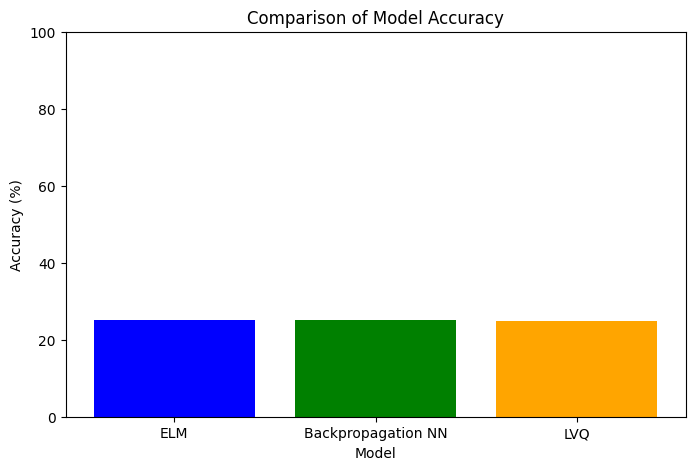

In [22]:
# Rekap hasil akurasi
results = {
    "ELM": accuracy_elm * 100,
    "Backpropagation NN": accuracy_bp * 100,
    "LVQ": accuracy_lvq * 100,
}


import matplotlib.pyplot as plt

# Data visualisasi
models = list(results.keys())
accuracies = list(results.values())

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0, 100)
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracy')
plt.show()


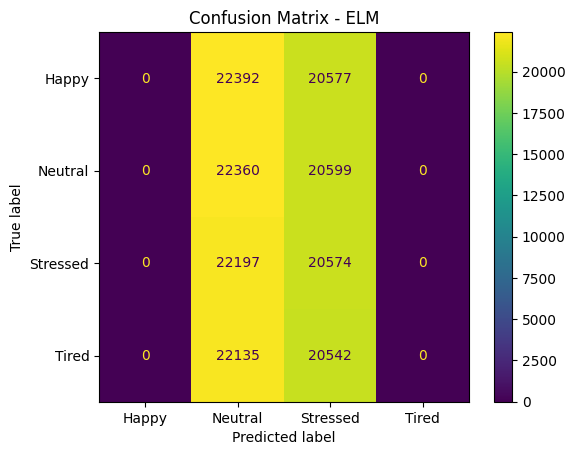

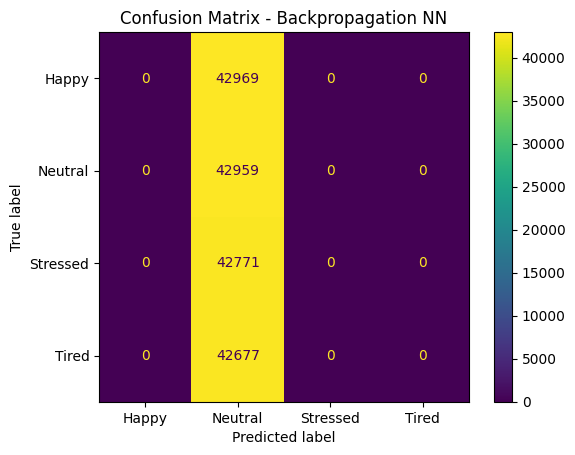

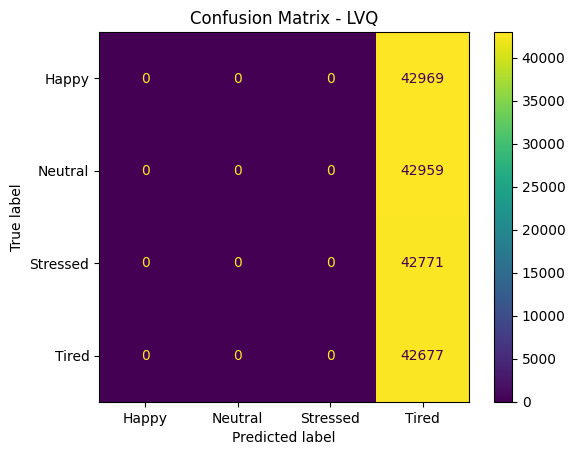

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_elm, y_pred_elm, display_labels=le.classes_)
plt.title('Confusion Matrix - ELM')
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test_bp, y_pred_bp, display_labels=le.classes_)
plt.title('Confusion Matrix - Backpropagation NN')
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test_lvq, y_pred_lvq, display_labels=le.classes_)
plt.title('Confusion Matrix - LVQ')
plt.show()


In [25]:
from sklearn.metrics import classification_report

print("Classification Report - ELM")
print(classification_report(y_test_elm, y_pred_elm, target_names=le.classes_))

print("\nClassification Report - Backpropagation NN")
print(classification_report(y_test_bp, y_pred_bp, target_names=le.classes_))

print("\nClassification Report - LVQ")
print(classification_report(y_test_lvq, y_pred_lvq, target_names=le.classes_))


Classification Report - ELM
              precision    recall  f1-score   support

       Happy       0.00      0.00      0.00     42969
     Neutral       0.25      0.52      0.34     42959
    Stressed       0.25      0.48      0.33     42771
       Tired       0.00      0.00      0.00     42677

    accuracy                           0.25    171376
   macro avg       0.13      0.25      0.17    171376
weighted avg       0.13      0.25      0.17    171376


Classification Report - Backpropagation NN


c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

       Happy       0.00      0.00      0.00     42969
     Neutral       0.25      1.00      0.40     42959
    Stressed       0.00      0.00      0.00     42771
       Tired       0.00      0.00      0.00     42677

    accuracy                           0.25    171376
   macro avg       0.06      0.25      0.10    171376
weighted avg       0.06      0.25      0.10    171376


Classification Report - LVQ
              precision    recall  f1-score   support

       Happy       0.00      0.00      0.00     42969
     Neutral       0.00      0.00      0.00     42959
    Stressed       0.00      0.00      0.00     42771
       Tired       0.25      1.00      0.40     42677

    accuracy                           0.25    171376
   macro avg       0.06      0.25      0.10    171376
weighted avg       0.06      0.25      0.10    171376



c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\FX506\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
